In [1]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
import random

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.lenses import lens_util
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure

In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
# debugging = True  # TODO TEMP

if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

detectable_lenses = lens_util.get_detectable_lenses(pipeline_dir, with_subhalos=False, verbose=True)

100%|██████████| 18/18 [00:16<00:00,  1.07it/s]


In [5]:
lens = SampleStrongLens()
roman = Roman()

band = 'F106'
scene_size = 5  # arcsec
oversample = 5
instrument_params = {'sca': 1,
                     'sca_position': (2048, 2048)}
exposure_time = 146

engine_params = {
    'rng': galsim.UniformDeviate(42)
}

Computing on pixel grid of size 235x235 (5.17"x5.17") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Computing with kwargs_numerics: {'supersampling_factor': 3, 'compute_mode': 'adaptive', 'supersampled_indexes': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F106 band
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F106_1_2048_2048_5_101.npy
Exposure calculation time with galsim engine: 0:00:00


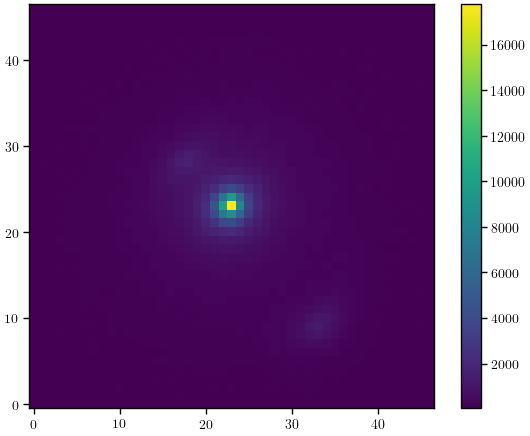

In [6]:
lens_1 = deepcopy(lens)
synth_1 = SyntheticImage(lens_1, roman, band=band, arcsec=scene_size, oversample=oversample,
                         instrument_params=instrument_params)
exposure_1 = Exposure(synth_1, exposure_time=146, engine='galsim', engine_params=engine_params, return_noise=True)

plt.imshow(exposure_1.exposure)
plt.colorbar()
plt.show()

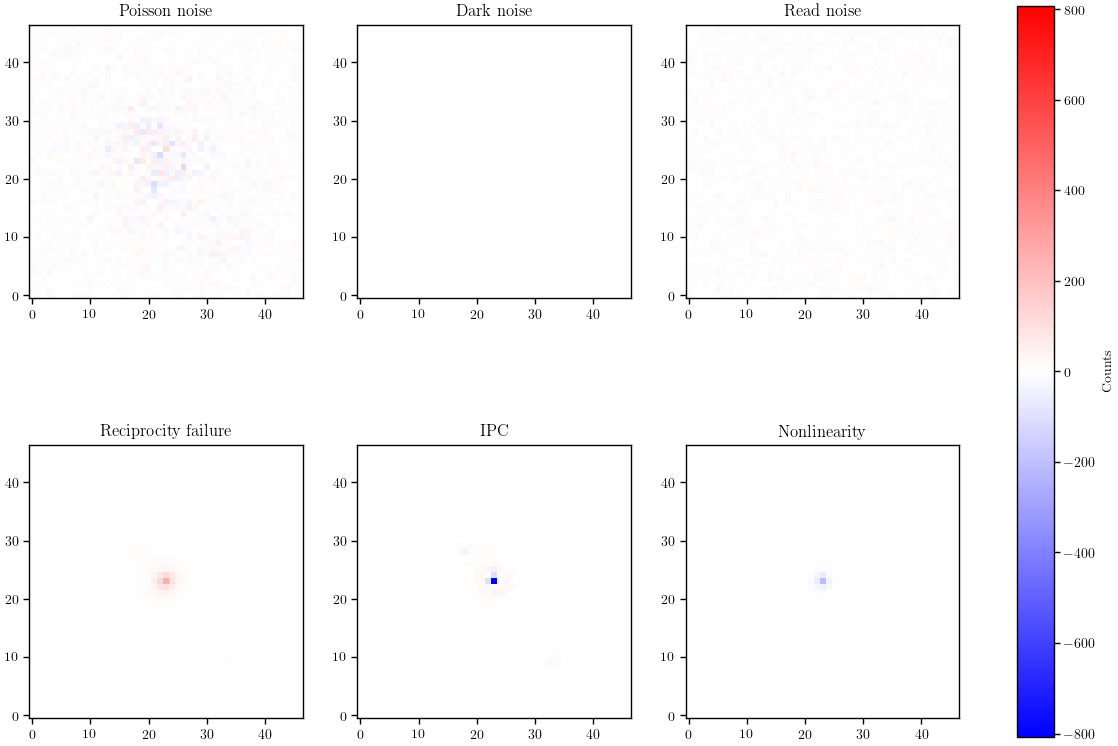

In [16]:
poisson_noise = exposure_1.poisson_noise
dark_noise = exposure_1.dark_noise
read_noise = exposure_1.read_noise
reciprocity_failure = exposure_1.reciprocity_failure
ipc = exposure_1.ipc
nonlinearity = exposure_1.nonlinearity

# Find the min and max values across all noise arrays to set a common color scale
vmin = min(poisson_noise.array.min(), dark_noise.array.min(), read_noise.array.min(),
           reciprocity_failure.array.min(), ipc.array.min(), nonlinearity.array.min())
vmax = max(poisson_noise.array.max(), dark_noise.array.max(), read_noise.array.max(),
           reciprocity_failure.array.max(), ipc.array.max(), nonlinearity.array.max())
v = max(abs(vmin), abs(vmax))

vmin = -v
vmax = v

_, ax = plt.subplots(2, 3, figsize=(15, 10))
im0 = ax[0, 0].imshow(poisson_noise.array, vmin=vmin, vmax=vmax, cmap='bwr')
ax[0, 0].set_title('Poisson noise')
im1 = ax[0, 1].imshow(dark_noise.array, vmin=vmin, vmax=vmax, cmap='bwr')
ax[0, 1].set_title('Dark noise')
im2 = ax[0, 2].imshow(read_noise.array, vmin=vmin, vmax=vmax, cmap='bwr')
ax[0, 2].set_title('Read noise')
im3 = ax[1, 0].imshow(reciprocity_failure.array, vmin=vmin, vmax=vmax, cmap='bwr')
ax[1, 0].set_title('Reciprocity failure')
im4 = ax[1, 1].imshow(ipc.array, vmin=vmin, vmax=vmax, cmap='bwr')
ax[1, 1].set_title('IPC')
im5 = ax[1, 2].imshow(nonlinearity.array, vmin=vmin, vmax=vmax, cmap='bwr')
ax[1, 2].set_title('Nonlinearity')

# Add a single colorbar for all subplots
fig = plt.gcf()
cbar = fig.colorbar(im5, ax=ax.ravel().tolist(), shrink=0.95)
cbar.set_label('Counts')

plt.show()

Computing on pixel grid of size 235x235 (5.17"x5.17") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Computing with kwargs_numerics: {'supersampling_factor': 3, 'compute_mode': 'adaptive', 'supersampled_indexes': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])}
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F106 band
Loading cached PSF: /data/bwedig/mejiro/cached_psfs/F106_1_2048_2048_5_101.npy
Exposure calculation time with galsim engine: 0:00:00


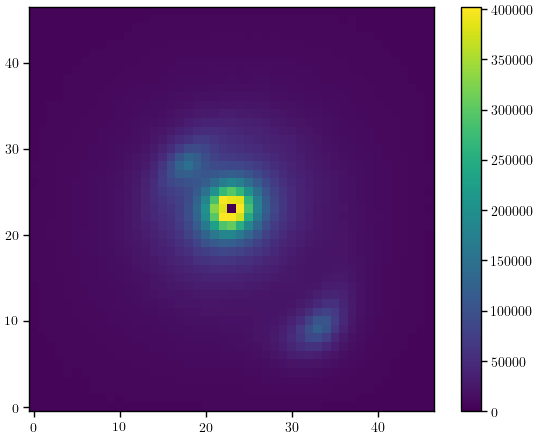

In [17]:
lens_2 = deepcopy(lens)
synth_2 = SyntheticImage(lens_2, roman, band=band, arcsec=scene_size, oversample=oversample,
                         instrument_params=instrument_params)
exposure_2 = Exposure(synth_2, exposure_time=14600, engine='galsim', engine_params=engine_params, return_noise=True)

plt.imshow(exposure_2.exposure)
plt.colorbar()
plt.show()

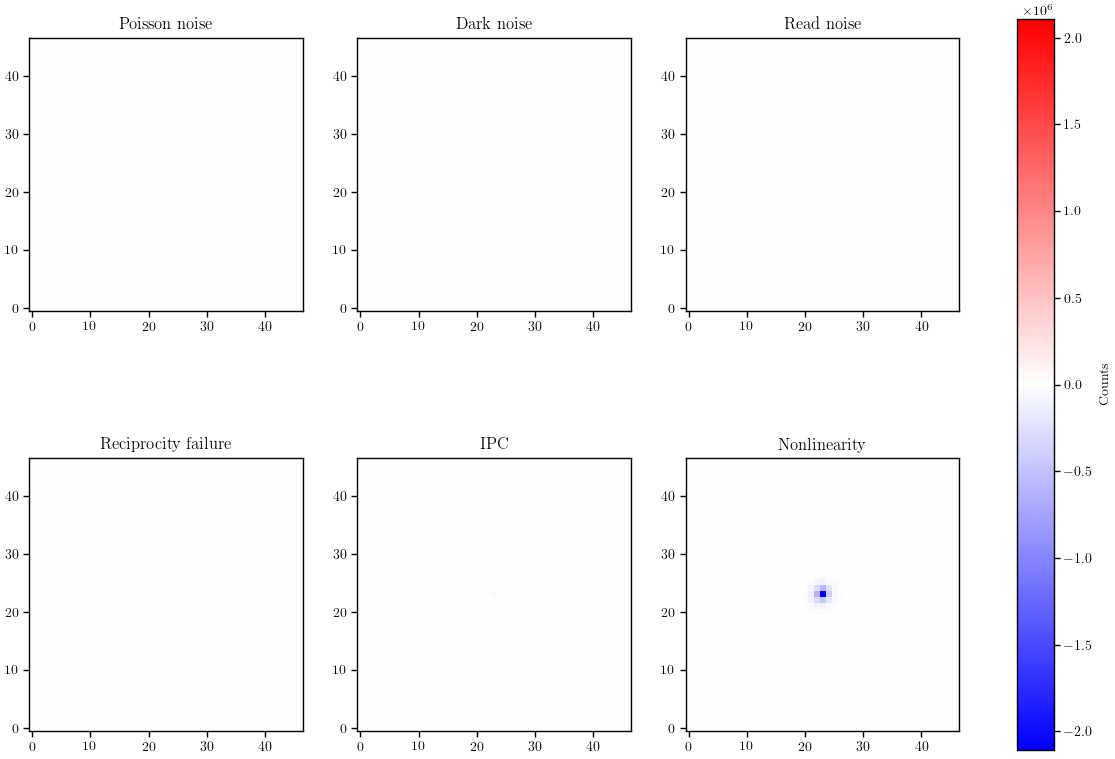

In [19]:
poisson_noise = exposure_2.poisson_noise
dark_noise = exposure_2.dark_noise
read_noise = exposure_2.read_noise
reciprocity_failure = exposure_2.reciprocity_failure
ipc = exposure_2.ipc
nonlinearity = exposure_2.nonlinearity

# Find the min and max values across all noise arrays to set a common color scale
vmin = min(poisson_noise.array.min(), dark_noise.array.min(), read_noise.array.min(),
           reciprocity_failure.array.min(), ipc.array.min(), nonlinearity.array.min())
vmax = max(poisson_noise.array.max(), dark_noise.array.max(), read_noise.array.max(),
           reciprocity_failure.array.max(), ipc.array.max(), nonlinearity.array.max())
v = max(abs(vmin), abs(vmax))

vmin = -v
vmax = v

_, ax = plt.subplots(2, 3, figsize=(15, 10))
im0 = ax[0, 0].imshow(poisson_noise.array, vmin=vmin, vmax=vmax, cmap='bwr')
ax[0, 0].set_title('Poisson noise')
im1 = ax[0, 1].imshow(dark_noise.array, vmin=vmin, vmax=vmax, cmap='bwr')
ax[0, 1].set_title('Dark noise')
im2 = ax[0, 2].imshow(read_noise.array, vmin=vmin, vmax=vmax, cmap='bwr')
ax[0, 2].set_title('Read noise')
im3 = ax[1, 0].imshow(reciprocity_failure.array, vmin=vmin, vmax=vmax, cmap='bwr')
ax[1, 0].set_title('Reciprocity failure')
im4 = ax[1, 1].imshow(ipc.array, vmin=vmin, vmax=vmax, cmap='bwr')
ax[1, 1].set_title('IPC')
im5 = ax[1, 2].imshow(nonlinearity.array, vmin=vmin, vmax=vmax, cmap='bwr')
ax[1, 2].set_title('Nonlinearity')

# Add a single colorbar for all subplots
fig = plt.gcf()
cbar = fig.colorbar(im5, ax=ax.ravel().tolist(), shrink=0.95)
cbar.set_label('Counts')

plt.show()

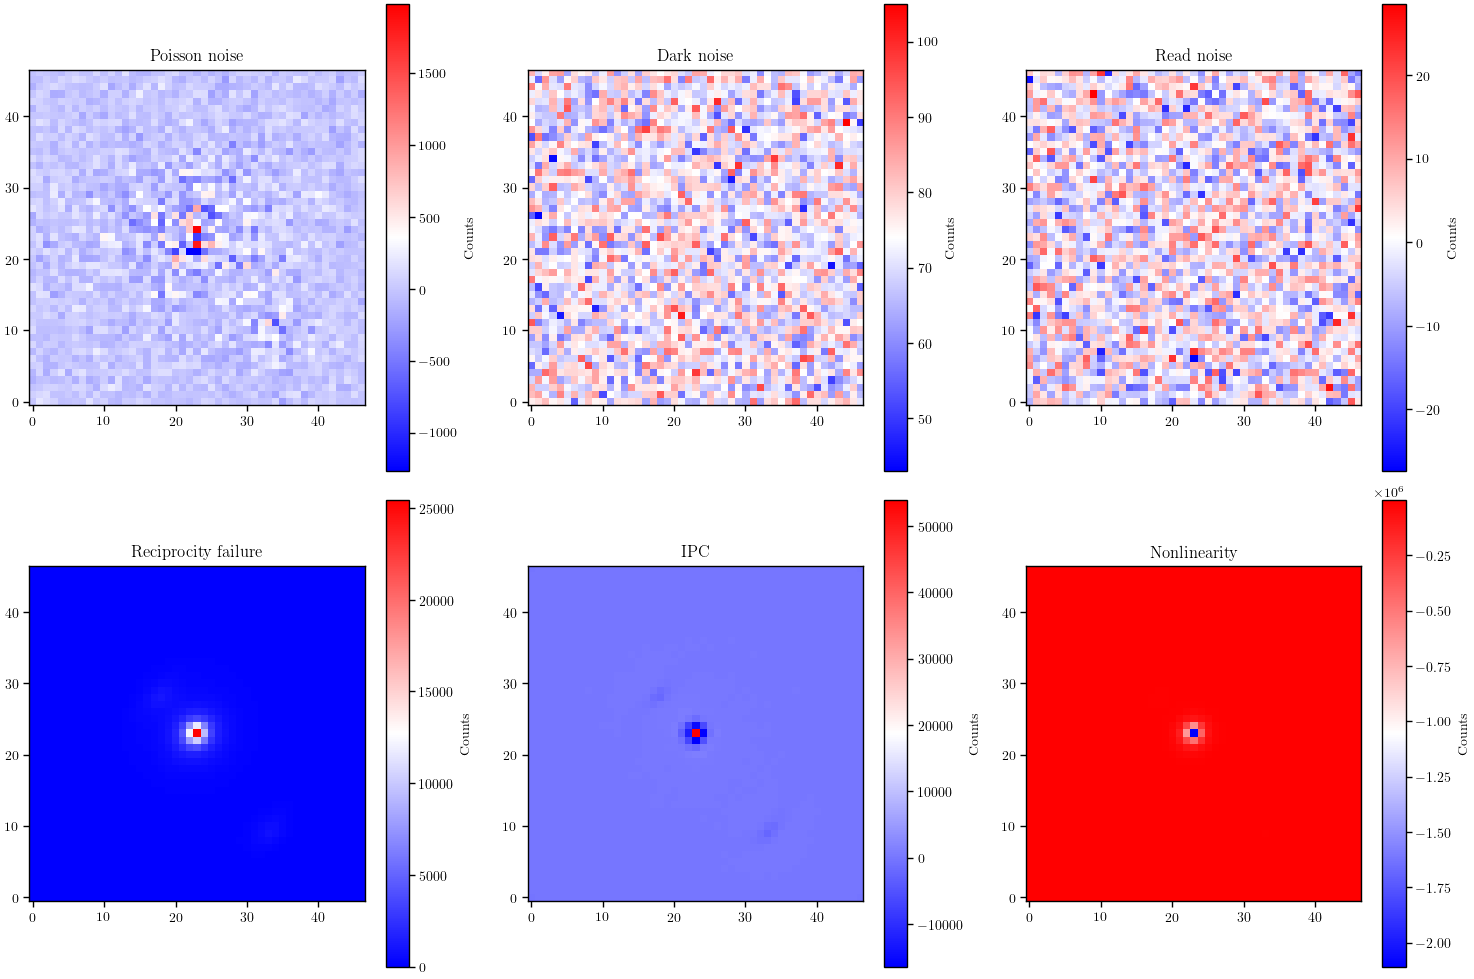

In [21]:
_, ax = plt.subplots(2, 3, figsize=(15, 10))

im0 = ax[0, 0].imshow(poisson_noise.array, cmap='bwr')
ax[0, 0].set_title('Poisson noise')
cbar0 = plt.colorbar(im0, ax=ax[0, 0])
cbar0.set_label('Counts')

im1 = ax[0, 1].imshow(dark_noise.array, cmap='bwr')
ax[0, 1].set_title('Dark noise')
cbar1 = plt.colorbar(im1, ax=ax[0, 1])
cbar1.set_label('Counts')

im2 = ax[0, 2].imshow(read_noise.array, cmap='bwr')
ax[0, 2].set_title('Read noise')
cbar2 = plt.colorbar(im2, ax=ax[0, 2])
cbar2.set_label('Counts')

im3 = ax[1, 0].imshow(reciprocity_failure.array, cmap='bwr')
ax[1, 0].set_title('Reciprocity failure')
cbar3 = plt.colorbar(im3, ax=ax[1, 0])
cbar3.set_label('Counts')

im4 = ax[1, 1].imshow(ipc.array, cmap='bwr')
ax[1, 1].set_title('IPC')
cbar4 = plt.colorbar(im4, ax=ax[1, 1])
cbar4.set_label('Counts')

im5 = ax[1, 2].imshow(nonlinearity.array, cmap='bwr')
ax[1, 2].set_title('Nonlinearity')
cbar5 = plt.colorbar(im5, ax=ax[1, 2])
cbar5.set_label('Counts')

plt.tight_layout()
plt.show()